In [7]:
from data_preprocessing.DataLoader import DataLoader
from data_preprocessing.DataPreprocessing import DataPreprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import pandas as pd
import datetime as dt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from data_preprocessing.DataLoader import DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
data = DataLoader.load_data_from_path("data/")
united = DataPreprocessing.prepareDate(data)

dataPreprocesing = DataPreprocessing()

united = dataPreprocesing.oneHotEncode(united, {'city', 'delivery_company', 'time_of_day', 'weekday'})

united['deltas'] = pd.to_numeric(united['deltas'].dt.days, downcast='integer')


# normalizacja deltas
# unitated['deltas'] = unitated['deltas'] /unitated['deltas'].abs().max()


train, test = train_test_split(united, test_size=0.2)
X_train = train.loc[:, train.columns != 'deltas']
y_train = train['deltas']

X_test = test.loc[:, test.columns != 'deltas']
y_test = test['deltas']


regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f'
% mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
% r2_score(y_test, y_pred))

Coefficients: 
 [ 3.80859331e+11  3.80859331e+11  3.80859331e+11 -2.57446672e+13
 -2.57446672e+13 -2.57446672e+13 -2.57446672e+13 -2.57446672e+13
 -2.57446672e+13 -2.57446672e+13 -2.57446672e+13 -1.31913943e+12
 -1.31913943e+12 -1.31913943e+12 -1.31913943e+12 -1.31913943e+12
 -1.31913943e+12 -1.31913943e+12  6.49142073e+10  6.49142073e+10
  6.49142073e+10  6.49142073e+10]
Mean squared error: 0.33
Coefficient of determination: 0.56


In [12]:
y_train

5262    2
2299    1
7000    2
578     3
1092    1
       ..
1837    2
3862    1
1314    1
3573    1
1279    3
Name: deltas, Length: 5994, dtype: int8

In [13]:
X_train

,delivery_company_360,delivery_company_516,delivery_company_620,city_Gdynia,city_Konin,city_Kutno,city_Mielec,city_Police,city_Radom,city_Szczecin,...,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
5262,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2299,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
7000,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
578,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1092,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3862,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1314,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3573,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [14]:
y_test.to_numpy()

array([1, 4, 0, ..., 1, 1, 0], dtype=int8)

In [15]:
y_pred.shape

(1499,)

In [16]:
y_test[0:10]

2864    1
4770    4
1368    0
5082    2
660     1
5548    3
931     1
661     0
2760    2
1439    2
Name: deltas, dtype: int8

In [17]:
y_pred[0:10]

array([1.38671875, 2.91015625, 0.80078125, 2.41796875, 1.1328125 ,
       2.96484375, 1.34375   , 0.7578125 , 1.6875    , 1.46875   ])

In [18]:
y_test[0:10]-y_pred[0:10]

2864   -0.386719
4770    1.089844
1368   -0.800781
5082   -0.417969
660    -0.132812
5548    0.035156
931    -0.343750
661    -0.757812
2760    0.312500
1439    0.531250
Name: deltas, dtype: float64

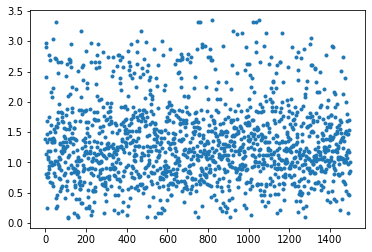

In [19]:
plt.plot(y_pred,".")

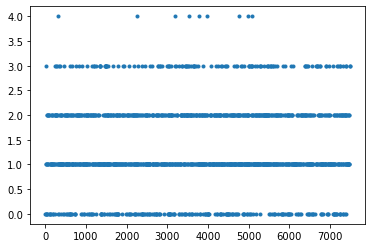

In [20]:
plt.plot(y_test,".")

In [22]:
import pickle
f = open('models/linear_regresion_1.0.0.pickle', 'wb')
pickle.dump(regr, f)
f.close()